In [1]:
import pandas as pd
import numpy as np
import nltk

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Embedding, LSTM, CuDNNLSTM
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

nltk.download('stopwords')

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/renatapva/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# import pre-processed files
twitter = pd.read_csv("twitter_pre_processed.csv");
wiki = pd.read_csv("wiki_pre_processed.csv");

# merging datasets
data = pd.concat([twitter, wiki]);

# remove stop words
stop_words = set(stopwords.words('english'))
data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]));

# stemming
stemmer = SnowballStemmer('english')
data['text'] = data['text'].apply(stemmer.stem)

# separate train and test datasets
y = data['class'];
X = data['text'];
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print('Training data count: ', X_train.count())
print('Test data count: ', X_test.count())

# creating dictionary
X_train = np.array(X_train)
X_test = np.array(X_test)

vectorizer = CountVectorizer(analyzer = 'word', max_features = 2000)
X_train = vectorizer.fit_transform(list(X_train))
X_test = vectorizer.transform(list(X_test))

Training data count:  147575
Test data count:  36894


In [3]:
# define network architecture and compile 
model = Sequential() 
model.add(Embedding(2000, 50))
model.add(Dropout(0.2)) 
model.add(CuDNNLSTM(50))
model.add(Dense(250, activation='relu')) 
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

In [ ]:
# train model
hist = model.fit(X_train, y_train, epochs=5, verbose=1, validation_split=0.1, batch_size=35)

Train on 132817 samples, validate on 14758 samples
Epoch 1/5
132817/132817 [==============================] - 405s 3ms/step - loss: 0.3075 - acc: 0.9090 - val_loss: 0.3102 - val_acc: 0.9059
Epoch 2/5
132817/132817 [==============================] - 399s 3ms/step - loss: 0.3009 - acc: 0.9091 - val_loss: 0.3022 - val_acc: 0.9059
Epoch 3/5
132817/132817 [==============================] - 399s 3ms/step - loss: 0.2983 - acc: 0.9091 - val_loss: 0.3004 - val_acc: 0.9059
Epoch 4/5
132817/132817 [==============================] - 399s 3ms/step - loss: 0.2976 - acc: 0.9091 - val_loss: 0.3029 - val_acc: 0.9059
Epoch 5/5
132817/132817 [==============================] - 398s 3ms/step - loss: 0.2971 - acc: 0.9091 - val_loss: 0.3010 - val_acc: 0.9059


In [5]:
# check score
score = model.evaluate(X_test, y_test, batch_size=35)
print(score)

36894/36894 [==============================] - 51s 1ms/step
[0.29479814034100532, 0.90963300804093572]


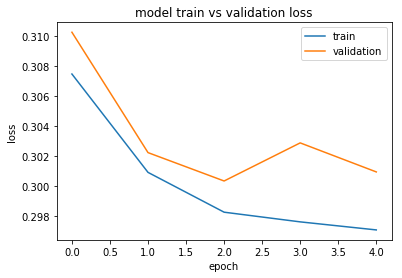

In [6]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [10]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred.round()))

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95     33560
         1.0       0.00      0.00      0.00      3334

   micro avg       0.91      0.91      0.91     36894
   macro avg       0.45      0.50      0.48     36894
weighted avg       0.83      0.91      0.87     36894



/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
